In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, set_seed

c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

C:\Users\steph\AppData\Local\Temp\ipykernel_23256\3171786389.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
import torchvision 
from torchvision import transforms

In [4]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)
x_example, y_example = mnist_data_train[0]
type(x_example)

100%|██████████| 9912422/9912422 [00:00<00:00, 16980122.57it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 3782653.44it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 15758656.79it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



PIL.Image.Image

In [5]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
print(x_example.shape)

torch.Size([1, 28, 28])


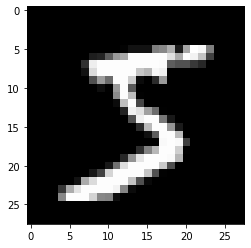

In [6]:
imshow(x_example[0,:], cmap='gray')

In [7]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


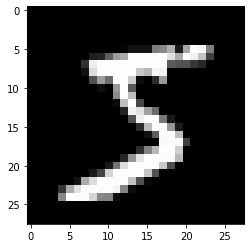

In [8]:
imshow(x_as_color.permute(1,2,0))

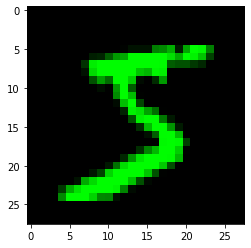

In [9]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])
x_as_color[0,:] = 0 #No Red
#Leaving green alone
x_as_color[2,:] = 0 #No Blue
imshow(x_as_color.permute(1,2,0))

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#how large should our filters be?
K = 3
#for comparison, lets define a linear model of similar complexity
model_linear = nn.Sequential(
  nn.Flatten(), #(B, C, W, H) -> (B, C*W*H) = (B,D)
  nn.Linear(D, 256), 
  nn.Tanh(),
  nn.Linear(256, classes),
)

#A simple convolutional network:
model_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  nn.Conv2d(C, filters, K, padding=K//2), #$x \circledast G$
  nn.Tanh(),#Activation functions work on any size tensor
  nn.Flatten(), #Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  nn.Linear(filters*D, classes),
)

In [11]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
fc_results = train_simple_network(model_linear, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Conected')